In [1]:
# ---
# title: "Connectivity Analyses"
# author: ["Maximilian A. Müller", "Gaizka Ormazabal", "Thorsten Sellhorn", "Victor Wagner"]
# institute: ["University of Cologne", "IESE", "LMU Munich School of Management", "LMU Munich School of Management"]
# number-sections: true

# toc: true
# format:
#     pdf:
#         geometry:
#             - paper = a4paper
#         fig-pos: 'h'
#     html:
#         toc: true
# jupyter: python3
# fig-width: 0.7
# ---

In [2]:
# echo: false
# output: asis

# # pdf:
# #         geometry:
# #             - paper=a4paper

# beamer:
#         aspectratio: 169
#         header-includes: |
#             \setbeamertemplate{navigation symbols}{}
#             \setbeamertemplate{footline}[page number]

# Technical stuff

::: {.callout-warning}
This is the technical step-by-step procedure. Not interesting.
:::

## Getting started
- imports
- SRN data
- (check which firms and documents are needed and which are already here); Currently, we base our analyses on the documents that have already been manually coded (bottom-up); in the future, however, we do it top-down based on Euro Stoxx 600
- read in document data
    - read in manually coded documents
    - check which have to be downloaded (b/c they are not here) and update
    - check which have to be extracted (b/c it hasn't been done) and update
    - prepare for later analysis and merge with other data

In [1]:
import sys, os, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# path to Dropbox directory with 'pdf', 'pdf-decrypt', 'docs_clean.json' and 'raw_texts.json'
BASE_PATH = "/Users/victor.wagner/Dropbox/_Connectivity-Data"
# BASE_PATH = "/Users/victorwagner/Library/CloudStorage/Dropbox/_Connectivity-Data"

In [2]:
API_PATH  = "https://api.sustainabilityreportingnavigator.com/api"

companies = pd.read_json(f'{API_PATH}/companies')
documents = pd.read_json(f'{API_PATH}/documents')
indices   = pd.read_json(f'{API_PATH}/indices')

In [3]:
es600 = companies[['1cc738c1-e6b1-4f2b-8bec-2d963118de59' in ind for ind in companies.indices]]

# es600 = es600[['id', 'name', 'isin', 'country', 'sector']].merge(
#     documents.query('type == "AR" & year in [2018, 2019, 2020, 2021, 2022]')[['id', 'year', 'type', 'company_id']], 
#     left_on='id', right_on='company_id',
#     suffixes=('_company', '_document')
# )

In [4]:
# set(es600.name).difference(set(manual_collections_all.name_comp))

### Read in manually collected start/end pages

In [5]:
from scripts.mergeManualCollections import mergeManualCollections
manual_collections_all = mergeManualCollections([
    '../data/connectivity-manual_collection - lmu_cologne.csv',
    '../data/connectivity-manual_collection-iese - main.csv',
    '../data/connectivity-manual_collection-iese - second_round.csv',
    '../data/connectivity-manual_collection-muhammad - lmu_only.csv',
    '../data/connectivity-manual_collection-parth - lmu_only.csv'
])

manual_collections = manual_collections_all.dropna(subset=['fs_begin', 'fs_end', 'audit_begin', 'audit_end'], how='any')

print('We have', len(manual_collections), 'manually coded documents, of which', 
      len(set(manual_collections.index).difference(set([x[:-4] for x in os.listdir(BASE_PATH + "/pdf/")]))),
      'are not downloaded.') 

if len([x[:-4] for x in os.listdir(BASE_PATH + "/pdf/")]) > len(manual_collections.index): 
    print('There are even', len(set([x[:-4] for x in os.listdir(BASE_PATH + "/pdf/")]).difference(set(manual_collections.index))),
      'documents too much.')

We have 1448 manually coded documents, of which 0 are not downloaded.
There are even 21 documents too much.


### Sample Balance Checks

In [6]:
worldscope_msci = pd.read_csv('../data/worldscope_msci_carbon.csv')

<ipython-input-6-111c8af92a56>:1: DtypeWarning: Columns (199,340) have mixed types. Specify dtype option on import or set low_memory=False.
  worldscope_msci = pd.read_csv('../data/worldscope_msci_carbon.csv')


In [7]:
es600a = es600.merge(
    worldscope_msci.query('year == 2022').drop_duplicates('id'),
    on="id",
    suffixes=("_comp", "_other"),
    indicator=True
)

In [8]:
sample    = es600a[es600a.id.isin(list(set(manual_collections.company_id)))]
all_es600 = es600a[es600a.id.isin(list(set(manual_collections_all.company_id)))]

In [9]:
from scripts.doBalanceChecks import balanceCheckMultiple
sampleCheck2 = pd.DataFrame(
    columns=['Sample', 'Full Euro STOXX 600', 'Difference', 'p-val']
)

print(
    balanceCheckMultiple(
        [
            {'name': 'Assets (bn$)',      'test': 'ttest',     'attrs': ['ITEM7230', 1000000000]},
            {'name': 'Sales (bn$)',       'test': 'ttest',     'attrs': ['ITEM7240', 1000000000]},
            {'name': 'Employees (,000)',  'test': 'ttest',     'attrs': ['ITEM7011', 1000]},
            {'name': 'MSCI Emiss. Score', 'test': 'ttest',     'attrs': ['mcarbon_emissions_score', 1]},
            {'name': '% GER',             'test': 'chisquare', 'attrs': ['country', 'Germany']},
            {'name': '% GBR',             'test': 'chisquare', 'attrs': ['country', 'United Kingdom']},
        ], 
        outDF = sampleCheck2,
        sample = sample,
        all_firms = all_es600
).to_markdown()
)

|                   |   Sample |   Full Euro STOXX 600 | Difference   | p-val   |
|:------------------|---------:|----------------------:|:-------------|:--------|
| Assets (bn$)      |    79.04 |                 78.47 | 0.57         | 0.97    |
| Sales (bn$)       |    19.53 |                 18.36 | 1.17         | 0.59    |
| Employees (,000)  |    42.6  |                 40.02 | 2.57         | 0.58    |
| MSCI Emiss. Score |     9.11 |                  9.14 | -0.03        | 0.71    |
| % GER             |     0.2  |                  0.12 | 0.08         | 0.8     |
| % GBR             |     0.25 |                  0.23 | 0.01         | 0.97    |
| n                 |   286    |                544    | -            | -       |


<div class="alert alert-block alert-danger"> Use the following with caution, this will download, extract and clean all documents if they are not stored locally. </div>

### Update pdfs if not all are downloaded yet

In [11]:
from scripts.downloadPdfs import downloadPdfs
doc_status = downloadPdfs(
    BASE_PATH,
    zip(manual_collections['href_doc'],
        manual_collections.index)
)
print('There were', sum([x == 'downloaded' for x in doc_status]), 'new downloads,', 
      sum([x == 'no download' for x in doc_status]), 'documents could not be downloaded.')

There were 0 new downloads, 0 documents could not be downloaded.


In [12]:
too_small_docs = [doc for doc in os.listdir(BASE_PATH + "/pdf/") if os.path.getsize((BASE_PATH+'/pdf/'+doc)) < 500000]
print('There are', len(too_small_docs), 'documents that are smaller than 0.5 MB (indicating corruption).')

# if len(too_small_docs) > 0:
#     manual_collections_all.loc[[x[:-4] for x in too_small_docs]].to_csv('corrupted_docs.csv')
#     print('A csv-file with a list of corrupted docs has been saved. Please download the docs manually.')

There are 271 documents that are smaller than 0.5 MB (indicating corruption).


### Extract text from pdfs if not done so yet

In [13]:
raw_texts_old = pd.read_json(f"{BASE_PATH}/pdf/../raw_texts.json")
print('We already have raw text for', len(raw_texts_old.query('status == "fine"')), 'documents, decrypting and reading',
     len(manual_collections)-len(raw_texts_old.query('status == "fine"')), 'documents now.')

from scripts.readTextFromPdf import readTextFromPdf
raw_texts_new, doc_status_new = [], []
raw_texts_new, doc_status_new = map(
    list, 
    zip(*[readTextFromPdf(BASE_PATH, doc_id) for doc_id in manual_collections.index])
)
raw_texts_newDict = {doc_id: (r,s) for doc_id,r,s in zip(manual_collections.index, raw_texts_new, doc_status_new)}

We already have raw text for 1185 documents, decrypting and reading 263 documents now.


In [14]:
from scripts.updateRawTexts import updateRawTexts
raw_texts_final = updateRawTexts(raw_texts_old, raw_texts_newDict)
raw_texts_final.to_json(f"{BASE_PATH}/pdf/../raw_texts.json")

print('There are', sum([x == 'problem_decrypting' for x in raw_texts_final.status]), 'documents with decryption problems', 
     'and', sum([x == 'problem_opening' for x in raw_texts_final.status]), 'documents that could not be read.')
print('This leaves us with a readable sample of', sum([x == 'fine' for x in raw_texts_final.status]), 'documents.')

There are 260 documents with decryption problems and 0 documents that could not be read.
This leaves us with a readable sample of 1185 documents.


### Clean text if not done so yet

In [15]:
docs_cleaned_old = pd.read_json(f"{BASE_PATH}/docs_clean.json")
print('There is already clean data for', len(docs_cleaned_old.query('status == "fine"')), 'documents, cleaning',
     len(raw_texts_final.query('status == "fine"'))-len(docs_cleaned_old.query('status == "fine"')), 'documents.')

from scripts.updateAndCleanText import updateAndCleanText
docs_cleaned_new = updateAndCleanText(docs_cleaned_old, raw_texts_final)
docs_cleaned_new.to_json(f"{BASE_PATH}/pdf/../docs_clean.json")

There is already clean data for 1177 documents, cleaning 8 documents.


In [16]:
del raw_texts_final, raw_texts_new, raw_texts_newDict, raw_texts_old
del docs_cleaned_old

### Merge other data to documents

In [76]:
# docs_cleaned_new.drop(columns=['clean_text_full'], inplace=True)

# docs = docs_cleaned_new.merge(
#     documents[['id', 'company_id', 'year']], 
#     left_index=True, right_on='id'
# ).merge(
#     companies[['id', 'name', 'isin', 'country', 'sector']], 
#     left_on='company_id', right_on='id',
#     suffixes=('', '_company')
# ).set_index(
#     'id', drop=True
# ).drop(
#     'id_company', axis=1
# )

In [ ]:
# This is better as it preserves 'new' documents found by RA's where no 
# document_id is in the SRN database

docs = pd.DataFrame(
    columns=list(docs_cleaned_new.columns) + ['document_id', 'year', 'company_id', 'name', 'isin', 'country', 'sector']
)

for doc_id, doc in docs_cleaned_new.iterrows():
    if '_' not in doc_id:
        company_id = documents[documents.id == doc_id]['company_id'].values[0]
        year       = documents[documents.id == doc_id]['year'].values[0]
        
    else:
        company_id = doc_id[:36]
        year       = doc_id[-4:]
        
    docs.loc[len(docs)] = [
        doc[0], doc[1], doc[2], doc[3], doc[4], doc[5], doc[6], doc[7], doc[8],
        doc_id,
        year,
        company_id,
        companies[companies.id == company_id]['name'].values[0],
        companies[companies.id == company_id]['isin'].values[0],
        companies[companies.id == company_id]['country'].values[0],
        companies[companies.id == company_id]['sector'].values[0]
    ]

docs.set_index('document_id', inplace=True)

### Merge manually coded section data

In [ ]:
docs = docs.merge(
    manual_collections[['mda_begin', 'mda_end', 'fs_begin', 'fs_end', 'audit_begin', 'audit_end']], 
    left_index=True, right_index=True
)

In [69]:
# docs = docs.reset_index(
# ).merge(
#     docs.groupby(
#         ['company_id']).size().reset_index(
#     ).rename(
#         columns={0: 'company_years_avlbl'}), on='company_id'
# ).set_index('index')

# # Drop obvious outlier
docs.drop(docs[(docs['isin'] == 'ES0130670112') & (docs['year'] == 2020)].index, inplace=True)

# Main analyses

## Document sample selection {#sec-doc-sample}

We distributed the EURO Stoxx 600 firms to student assistants to extract information on the structure of annual reports.
So far, this resulted in the following documents sample: 
1. after removing not readable pdfs,
2. pdfs where no text was scanned, and 
3. pdfs with too little words (documents where the average clean text characters are less than 1,500 in a document).

In [ ]:
docs0 = docs.query('status == "fine"')
docs1 = docs0.query('clean_text_len > 0')
docs2 = docs1.query('avgCleanTextPerPage > 1500')

TpdfSample = pd.DataFrame(columns=['', 'less', 'resulting'])

TpdfSample.loc[len(TpdfSample),:] = ['downloaded pdfs',    '',                             len(docs)]
TpdfSample.loc[len(TpdfSample),:] = ['not readable',       '-'+str(len(docs) -len(docs0)), len(docs0)]
TpdfSample.loc[len(TpdfSample),:] = ['zero text scanned',  '-'+str(len(docs0)-len(docs1)), len(docs1)]
TpdfSample.loc[len(TpdfSample),:] = ['chars/page < 1,500', '-'+str(len(docs1)-len(docs2)), len(docs2)]

#print(TpdfSample.to_markdown(index=False))
#print('\nThis leaves us with', len(docs2['company_id'].unique()), 'unique firms.')

In [103]:
#| label: tbl-documents-sample
#| tbl-cap: Sample selection documents
#| tbl-cap-location: top
#| tbl-width: 80%
#| tbl-colwidths: [50,25,25]
TpdfSample.reset_index(drop=True)

,,less,resulting
0,downloaded pdfs,,1209
1,not readable,-234,975
2,zero text scanned,-33,942
3,"chars/page < 1,500",-131,811


## Keyword search

In [14]:
from findSections import findSections
pd.options.mode.chained_assignment = None  # default='warn'

docsa = findSections(docs2)

In [304]:
#| label: search-patterns
search_patterns = ['ghg', 'co2', 'carbon', 'climat', 'emission', 'regulatory risk', 'physical risk', 'transition risk']
print(search_patterns)

['ghg', 'co2', 'carbon', 'climat', 'emission', 'regulatory risk', 'physical risk', 'transition risk']


In [16]:
lim = 200

def searchText(doc, search_patterns):
    matches = []
    for section in ['mda_text', 'fs_text', 'audit_text', 'other_text']:
        for pat in search_patterns:
            for page, text in doc[section+'_dict'].items():
                for hit in re.finditer(pat, text):
                    matches.append({
                        'pattern': pat,
                        'section': section[:-5],
                        'snippet': text[hit.start()-lim : hit.start()+len(pat)+lim],
                        'page'   : page
                    })
                
    return matches

docsa['hits'] = [pd.DataFrame(searchText(doc, search_patterns)) for _, doc in docsa.iterrows()]

In [40]:
lim = 200

def searchText(doc, search_patterns):
    matches = []
    for section in ['mda_text', 'fs_text', 'audit_text', 'other_text']:
        for pat in search_patterns:
            for page, text in doc[section+'_dict'].items():
                for hit in re.finditer(pat, text):
                    matches.append({
                        'pattern': pat,
                        'section': section[:-5],
                        'snippet': text[hit.start()-lim : hit.start()+len(pat)+lim],
                        'page'   : page
                    })
                
    return matches

docsa['finhits'] = [pd.DataFrame(searchText(doc, ['asset', 'revenue', 'sales', 'employee'])) for _, doc in docsa.iterrows()]

In [46]:
docsa['total_hits']    = [len(doc.hits) for _, doc in docsa.iterrows()]
docsa['total_finhits'] = [len(doc.finhits) for _, doc in docsa.iterrows()]

In [564]:
# for sec in sections:
#     docsamax[sec+'_hit'] = [len(list(filter(lambda hit: hit['section'] == sec, searchText(doc, search_patterns)))) for _, doc in docsa.iterrows()]
    
# for pat in search_patterns:
#     docsamax[pat+'_hit'] = [len(list(filter(lambda hit: hit['pattern'] == pat, searchText(doc, search_patterns)))) for _, doc in docsa.iterrows()]
#     docsamax[pat+'_fs_hit'] = [len(list(filter(lambda hit: (hit['pattern'] == pat) and (hit['section'] == 'fs'), searchText(doc, search_patterns)))) for _, doc in docsa.iterrows()]
    

In [519]:
# snippets = pd.DataFrame(columns=['document_id', 'isin', 'year', 'pattern', 'section', 'snippet'])

# for idx, doc in docsa.iterrows():
#     for _, hit in doc.hits.iterrows():
#         snippets.loc[len(snippets)] = [idx, doc['isin'], doc['year'], hit['pattern'], hit['section'], hit['snippet']]
    
# snippets.info()
# snippets.to_csv('snippets.csv', index=False)

# Analyses

In [266]:
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
mpl.rcParams['figure.dpi'] = 100
sections = ['fs', 'audit', 'mda', 'other']
years = sorted(docsa.year.unique())
colors = ['#ff1f5b', '#009ade', '#af58ba', '#ffc61e']

NameError: name 'docsa' is not defined

## Sample and method
- We downloaded 961 annual reports from Euro Stoxx 600 firms in pdf format
- After cleaning (see more @sec-doc-sample), we were able to extract text from 611 documents
- We then manually classified different sections of these reports
    - MD&A (a.k.a. management report, Lagebericht, etc.)
    - Financial Statements and Notes
    - Auditor's Report
- And searched for climate-related keywords

## Keywords over time

In [18]:
data = docsa.copy()

for sec in sections:
    data[sec+'_hits'] = [len(list(filter(lambda hit: hit['section'] == sec, searchText(doc, search_patterns)))) for _, doc in docsa.iterrows()]

data['total_hits'] = [len(searchText(doc, search_patterns)) for _, doc in docsa.iterrows()]

In [19]:
avg_hits_perSec_perYear = [[np.mean(data.query('year == @year')[sec+'_hits']) for year in years] for sec in sections]
med_hits_perSec_perYear = [[np.median(data.query('year == @year')[sec+'_hits']) for year in years] for sec in sections]
avg_hitsPerPage_perSec_perYear = [[np.mean(data.query('year == @year')[sec+'_hits']/data.query('year == @year')['n_pages']) for year in years] for sec in sections]

In [220]:
fs_hits_avg_yrs =    [np.mean(data.query('year == @year')['fs_hits'])    for year in years]
audit_hits_avg_yrs = [np.mean(data.query('year == @year')['audit_hits']) for year in years]
mda_hits_avg_yrs =   [np.mean(data.query('year == @year')['mda_hits'])   for year in years]
other_hits_avg_yrs = [np.mean(data.query('year == @year')['other_hits']) for year in years]

fs_hits_med_yrs =    [np.median(data.query('year == @year')['fs_hits'])    for year in years]
audit_hits_med_yrs = [np.median(data.query('year == @year')['audit_hits']) for year in years]
mda_hits_med_yrs =   [np.median(data.query('year == @year')['mda_hits'])   for year in years]
other_hits_med_yrs = [np.median(data.query('year == @year')['other_hits']) for year in years]

In [20]:
fs_hits_byY = [data.query('year == @year')['fs_hits'].values for year in years]
fs_hits_ci  = [stats.t.interval(0.95, len(hits_byY)-1, loc=hits_byY.mean(), scale=hits_byY.std()) for hits_byY in fs_hits_byY]
fs_hits_iqr = [stats.iqr(x) for x in fs_hits_byY]
fs_hits_q1  = [np.quantile(data.query('year == @year')['fs_hits'], 0.25) for year in years]
fs_hits_q3  = [np.quantile(data.query('year == @year')['fs_hits'], 0.75) for year in years]

audit_hits_byY = [data.query('year == @year')['audit_hits'].values for year in years]
audit_hits_ci  = [stats.t.interval(0.95, len(hits_byY)-1, loc=hits_byY.mean(), scale=hits_byY.std()) for hits_byY in audit_hits_byY]
audit_hits_iqr = [stats.iqr(x) for x in audit_hits_byY]
audit_hits_q1  = [np.quantile(data.query('year == @year')['audit_hits'], 0.25) for year in years]
audit_hits_q3  = [np.quantile(data.query('year == @year')['audit_hits'], 0.75) for year in years]

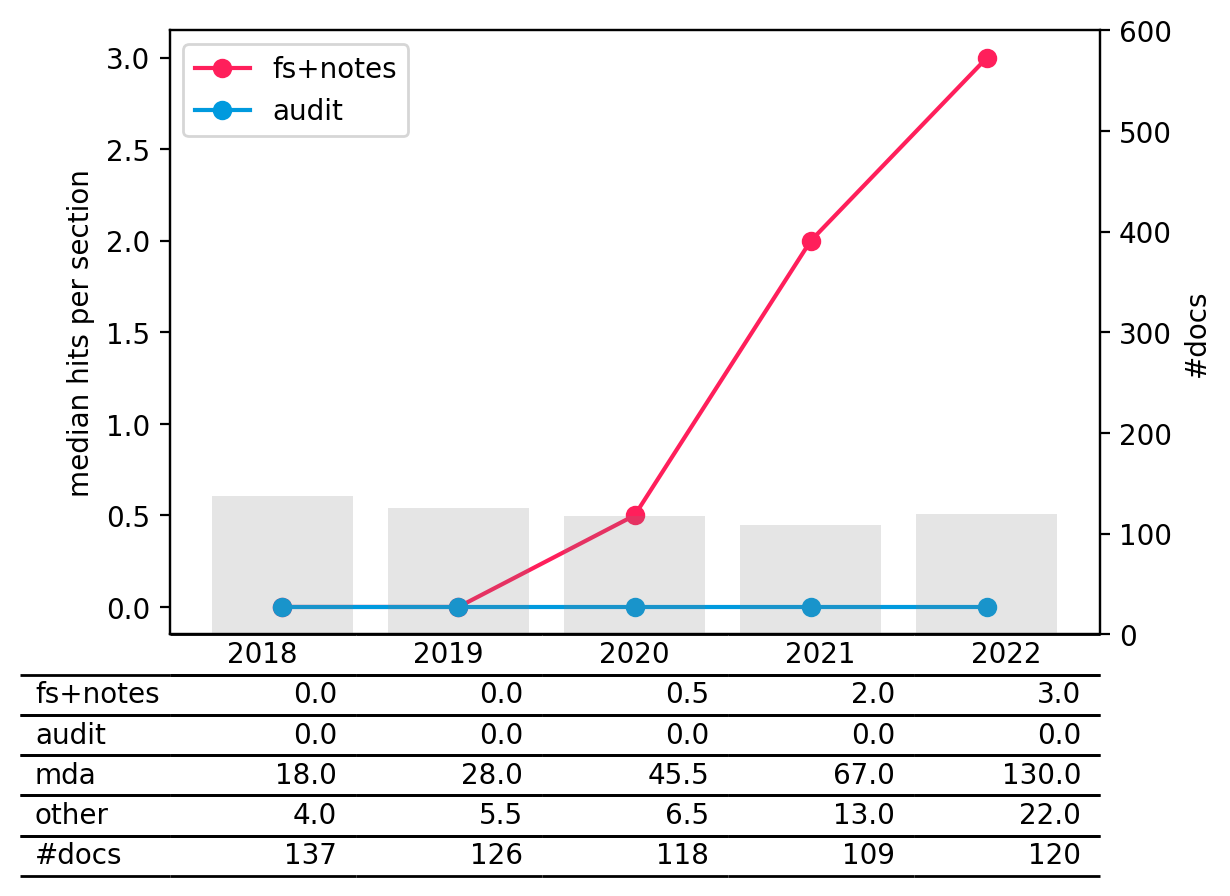

In [598]:
fig, ax1 = plt.subplots()

ax1.plot(years, med_hits_perSec_perYear[0], 'o-', color='#ff1f5b', label='fs+notes')
ax1.plot(years, med_hits_perSec_perYear[1], 'o-', color='#009ade', label='audit')

# for year, n in zip(years, range(len(years))):
#     ax1.plot(
#         (year, year), 
#         (med_hits_perSec_perYear[0][n]+fs_hits_q3[n], 
#          med_hits_perSec_perYear[0][n]-fs_hits_q1[n]), 
#         '_-', color='#ff1f5b', alpha=0.5
#     )
#     ax1.plot(
#         (year, year), 
#         (med_hits_perSec_perYear[1][n]+audit_hits_q3[n], 
#          med_hits_perSec_perYear[1][n]-audit_hits_q1[n]), 
#         '_-', color='#009ade', alpha=0.5
#     )

ax1.set_ylabel('median hits per section')

docsPerYear = [len(data.query('year == @year')) for year in years]
ax2 = ax1.twinx()
ax2.bar(x=years, height=docsPerYear, color='gray', alpha=0.2)
ax2.set_ylim([0,600])
ax2.tick_params(axis='y')
ax2.set_ylabel('#docs')

plt.table([[round(y, 2) for y in x] for x in med_hits_perSec_perYear+[docsPerYear]],
         rowLabels=['fs+notes', 'audit', 'mda', 'other', '#docs'],
         rowColours=['#ff1f5b', '#009ade', '#ffffff', '#ffffff', 'lightgray'],
         colLabels=years, loc='bottom', cellLoc='right', edges='horizontal', bbox=[0, -0.4, 1, 0.4])

ax1.set_xticks([])
ax2.set_xticks([])
#ax1.set_title(f'n={len(data)} reports with {sum(data["total_hits"])} total keyword hits with IQR')
ax1.legend()#ncol=4, bbox_to_anchor=(0.75,-0.1))

#fig.savefig('figures/fig202309271823.png', dpi=400, bbox_inches='tight')
plt.show()

In [26]:
from scipy.interpolate import make_interp_spline
splined_fs    = make_interp_spline(years, avg_hits_perSec_perYear[0])
splined_audit = make_interp_spline(years, avg_hits_perSec_perYear[1])

years_spl = np.linspace(min(years), max(years), 500)
y_fs      = splined_fs(years_spl)
y_audit   = splined_audit(years_spl)

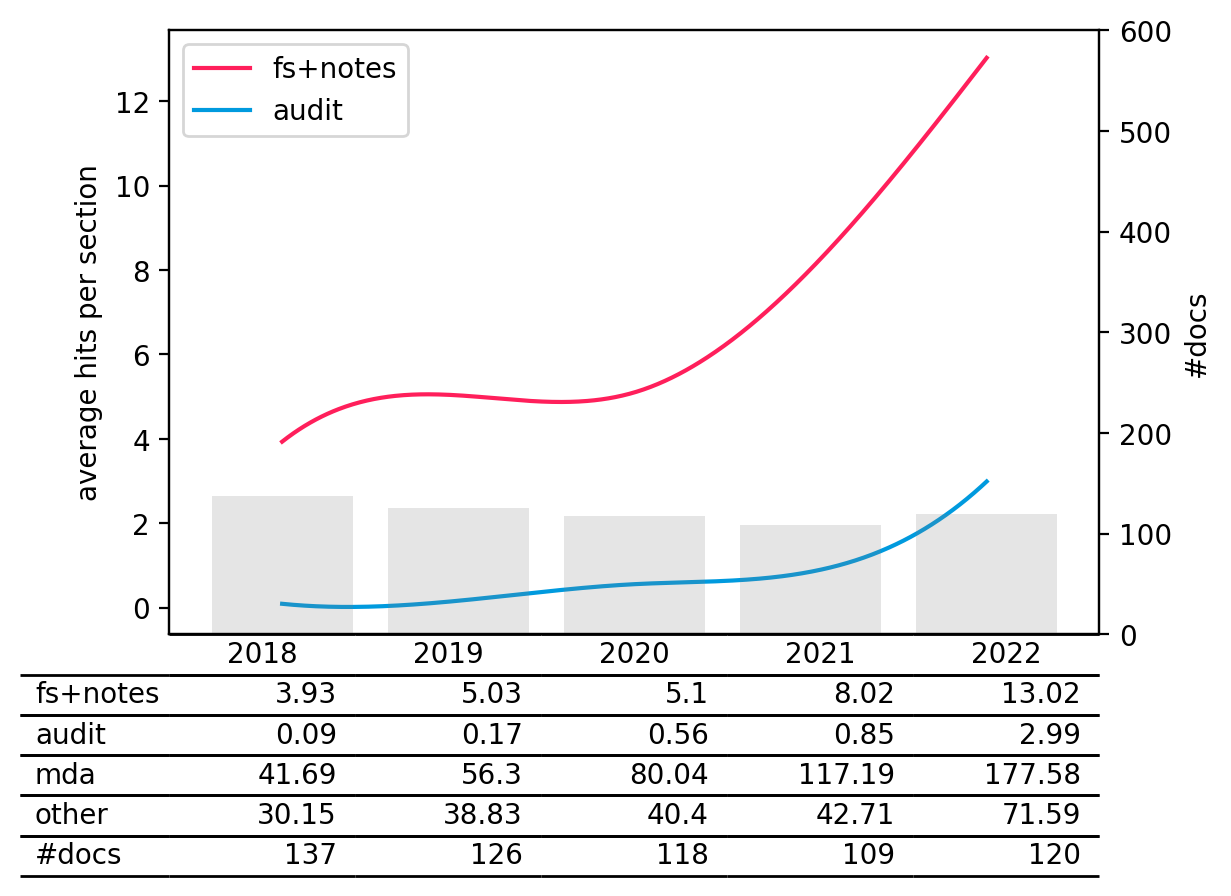

In [30]:
#| label: fig-fig202309281056
#| fig-cap: Development of average hits
fig, ax1 = plt.subplots()

ax1.plot(years_spl, y_fs, '-', color='#ff1f5b', label='fs+notes')
ax1.plot(years_spl, y_audit, '-', color='#009ade', label='audit')

# for year, n in zip(years, range(len(years))):
#     ax1.plot(
#         (year, year), 
#         (avg_hits_perSec_perYear[0][n]+fs_hits_ci[n][0], 
#          avg_hits_perSec_perYear[0][n]+fs_hits_ci[n][1]), 
#         '_-', color='#ff1f5b', alpha=0.5)
#     ax1.plot(
#         (year, year), 
#         (avg_hits_perSec_perYear[1][n]+audit_hits_ci[n], 
#          avg_hits_perSec_perYear[1][n]+audit_hits_ci[n]), 
#         '_-', color='#009ade', alpha=0.5)

ax1.set_ylabel('average hits per section')

docsPerYear = [len(data.query('year == @year')) for year in years]
ax2 = ax1.twinx()
ax2.bar(x=years, height=docsPerYear, color='gray', alpha=0.2)
ax2.set_ylim([0,600])
ax2.tick_params(axis='y')
ax2.set_ylabel('#docs')

plt.table([[round(y, 2) for y in x] for x in avg_hits_perSec_perYear+[docsPerYear]],
         rowLabels=['fs+notes', 'audit', 'mda', 'other', '#docs'],
         rowColours=['#ff1f5b', '#009ade', '#ffffff', '#ffffff', 'lightgray'],
         colLabels=years, loc='bottom', cellLoc='right', edges='horizontal', bbox=[0, -0.4, 1, 0.4])

ax1.set_xticks([])
ax2.set_xticks([])
#ax1.set_title(f'n={len(data)} reports with {sum(data["total_hits"])} total keyword hits with IQR')
ax1.legend()#ncol=4, bbox_to_anchor=(0.75,-0.1))

#fig.savefig('figures/fig202309280927.png', dpi=400, bbox_inches='tight')
plt.show()

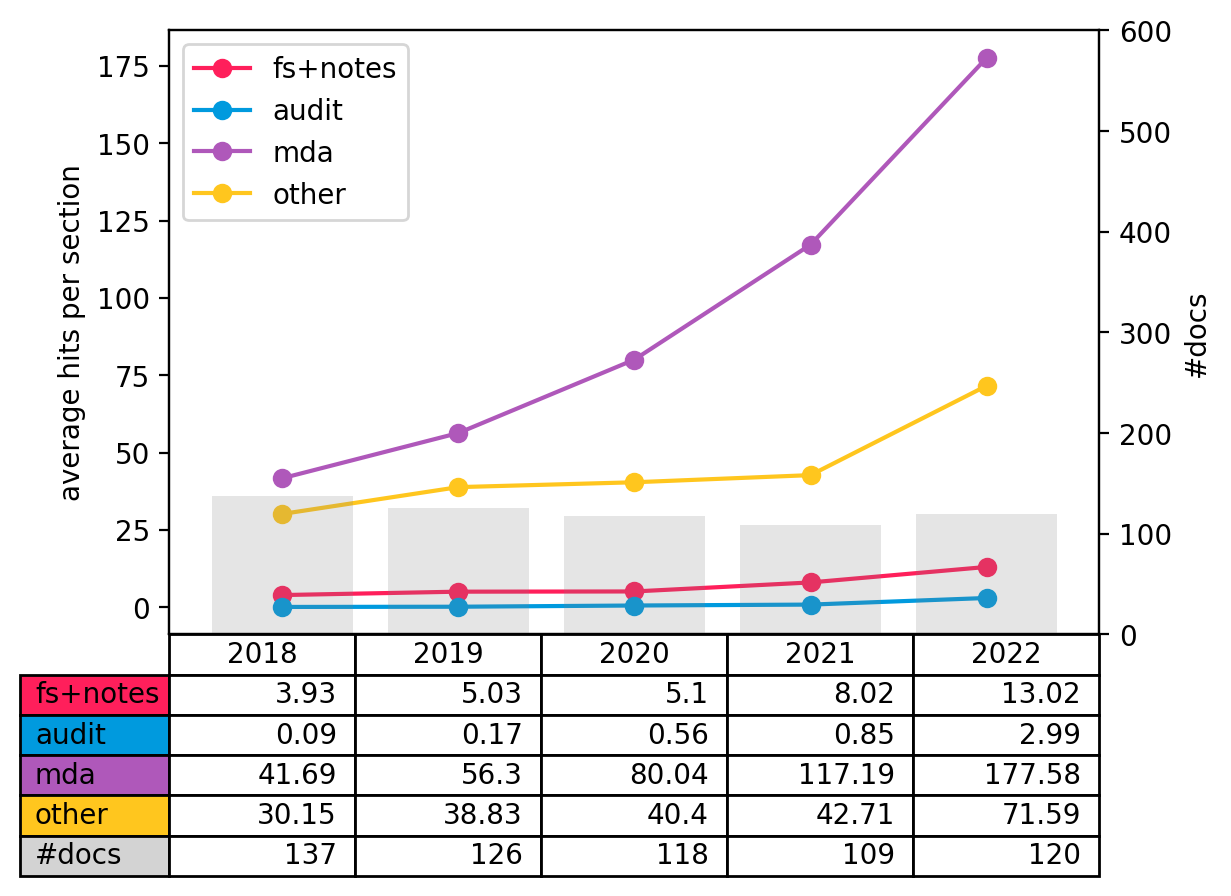

In [130]:
#| label: fig-fig202309271823
#| fig-cap: Development of average hits
fig, ax1 = plt.subplots()

ax1.plot(years, avg_hits_perSec_perYear[0],    'o-', color='#ff1f5b', label='fs+notes')
ax1.plot(years, avg_hits_perSec_perYear[1], 'o-', color='#009ade', label='audit')
ax1.plot(years, avg_hits_perSec_perYear[2],   'o-', color='#af58ba', label='mda')
ax1.plot(years, avg_hits_perSec_perYear[3], 'o-', color='#ffc61e', label='other')

ax1.set_ylabel('average hits per section')

docsPerYear = [len(data.query('year == @year')) for year in years]
ax2 = ax1.twinx()
ax2.bar(x=years, height=docsPerYear, color='gray', alpha=0.2)
ax2.set_ylim([0,600])
ax2.tick_params(axis='y')
ax2.set_ylabel('#docs')

plt.table([[round(y, 2) for y in x] for x in avg_hits_perSec_perYear+[docsPerYear]],
         rowLabels=['fs+notes', 'audit', 'mda', 'other', '#docs'],
         rowColours=['#ff1f5b', '#009ade', '#af58ba', '#ffc61e', 'lightgray'],
         colLabels=years, loc='bottom', cellLoc='right', bbox=[0, -0.4, 1, 0.4])

ax1.set_xticks([])
ax2.set_xticks([])
#ax1.set_title(f'n={len(data)} reports with {sum(data["total_hits"])} total keyword hits')
ax1.legend()#ncol=4, bbox_to_anchor=(0.75,-0.1))

#fig.savefig('figures/fig202309272029.png', dpi=400, bbox_inches='tight')
plt.show()

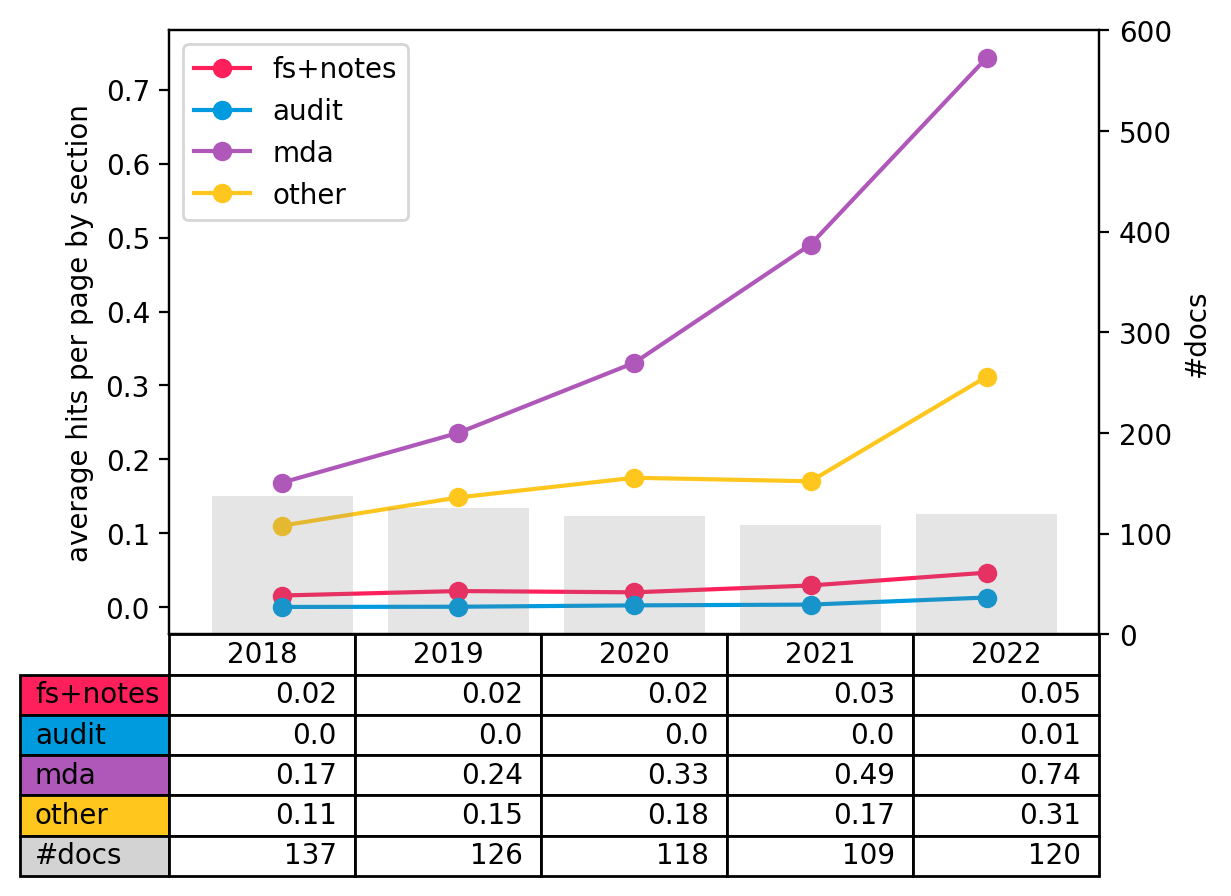

In [131]:
#| label: fig-fig202309281057
#| fig-cap: Development of hits per page
fig, ax1 = plt.subplots()

ax1.plot(years, avg_hitsPerPage_perSec_perYear[0], 'o-', color='#ff1f5b', label='fs+notes')
ax1.plot(years, avg_hitsPerPage_perSec_perYear[1], 'o-', color='#009ade', label='audit')
ax1.plot(years, avg_hitsPerPage_perSec_perYear[2], 'o-', color='#af58ba', label='mda')
ax1.plot(years, avg_hitsPerPage_perSec_perYear[3], 'o-', color='#ffc61e', label='other')

ax1.set_ylabel('average hits per page by section')

docsPerYear = [len(data.query('year == @year')) for year in years]
ax2 = ax1.twinx()
ax2.bar(x=years, height=docsPerYear, color='gray', alpha=0.2)
ax2.set_ylim([0,600])
ax2.tick_params(axis='y')
ax2.set_ylabel('#docs')

plt.table([[round(y, 2) for y in x] for x in avg_hitsPerPage_perSec_perYear+[docsPerYear]],
         rowLabels=['fs+notes', 'audit', 'mda', 'other', '#docs'],
         rowColours=['#ff1f5b', '#009ade', '#af58ba', '#ffc61e', 'lightgray'],
         colLabels=years, loc='bottom', cellLoc='right', bbox=[0, -0.4, 1, 0.4])

ax1.set_xticks([])
ax2.set_xticks([])
#ax1.set_title(f'n={len(data)} reports with {sum(data["total_hits"])} total keyword hits')
ax1.legend()#ncol=4, bbox_to_anchor=(0.75,-0.1))

#fig.savefig('figures/fig202309272029.png', dpi=400, bbox_inches='tight')
plt.show()

## Keyword distribution in the reports

In [ ]:
# fig, ax = plt.subplots(1,4,figsize=(12,3), sharey=True)

# #ax[0].hist(data.total_hits, color='lightgray')
# ax[0].hist(data.fs_hits,    color='#ff1f5b')
# ax[1].hist(data.audit_hits, color='#009ade')
# ax[2].hist(data.mda_hits,   color='#af58ba')
# ax[3].hist(data.other_hits, color='#ffc61e')

# for n, title in zip(range(4), ['fs+notes', 'audit', 'mda', 'other']):
#     ax[n].set_title(title)

# plt.suptitle(f'Distribution of hits per document by section', y=1.1)
# plt.savefig('figures/fig202309271836.png', dpi=400, bbox_inches='tight')

## Keyword ranking

In [132]:
data = docsa.copy()

for pat in search_patterns:
    data[pat] = [len(list(filter(lambda hit: hit['pattern'] == pat, searchText(doc, search_patterns)))) for _, doc in docsa.iterrows()]
    
data['total_hits'] = [len(searchText(doc, search_patterns)) for _, doc in docsa.iterrows()]

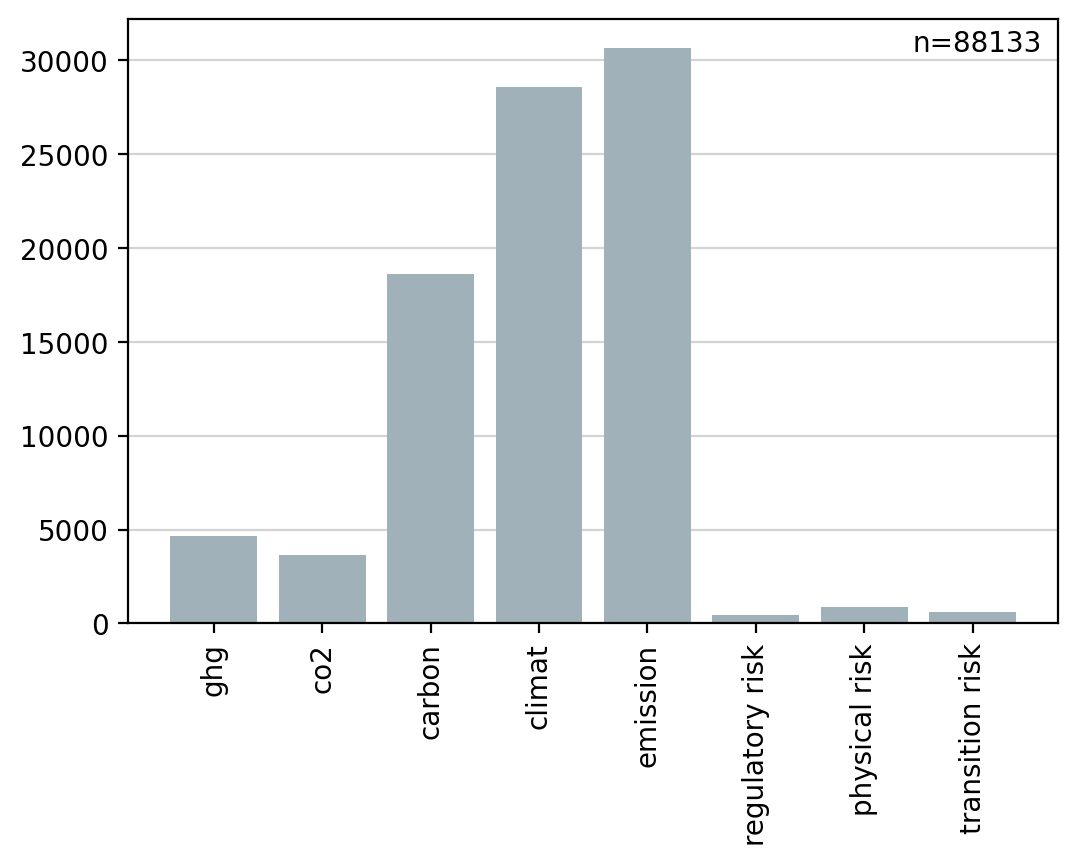

In [133]:
#| label: fig-fig202309281109
#| fig-cap: keyword ranking
fig, ax = plt.subplots()

ax.bar(search_patterns, [np.sum(data[pat].values) for pat in search_patterns], color='#a0b1ba', zorder=2)
#ax.set_title(f'Distribution of hits per keyword (total hits={sum(data.total_hits)})')
ax.text(6.45,30500,f'n={sum(data.total_hits)}')

plt.grid(axis='y', color='lightgray', zorder=0)

plt.xticks(rotation=90)
plt.savefig('figures/fig202309272100.png', dpi=400, bbox_inches='tight')

## Keyword ranking by section
The difference b/w the total number of search hits is because from here, I included `ghg` and `co2`

In [134]:
sections = ['fs', 'audit', 'mda', 'other']

totals = {k:v for k,v in zip(
    sections,
    [[sum(len(list(filter(lambda hit: (hit['section'] == sec) & (hit['pattern'] == pat), searchText(doc, search_patterns))))
          for _, doc in docsa.iterrows()) 
      for pat in search_patterns] 
     for sec in sections]
)}

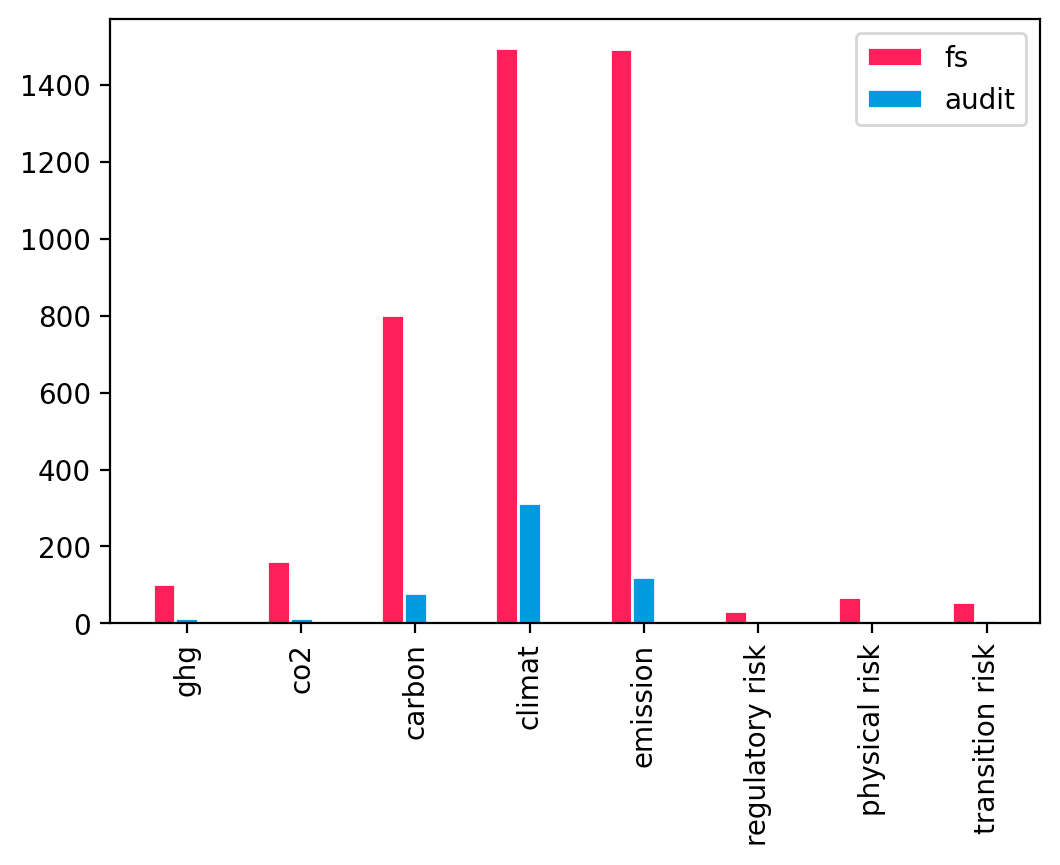

In [135]:
#| label: fig-fig202309281112
#| fig-cap: Keyword ranking by section
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#ff1f5b', '#009ade', '#af58ba', '#ffc61e'])

fig, ax = plt.subplots()

width = 0.2
label_locs = np.arange(len(search_patterns))
multiplier = 0

for sec in list(totals.keys())[:2]:
    offset = width * multiplier
    ax.bar(label_locs+offset, totals[sec], width=width, label=sec, edgecolor='w')
    #ax.bar_label(rects, padding=3)
    multiplier += 1
    
ax.set_xticks(label_locs+width)
ax.set_xticklabels(search_patterns)
plt.xticks(rotation=90)
ax.legend()

plt.savefig('figures/fig202309272158.png', dpi=400, bbox_inches='tight')

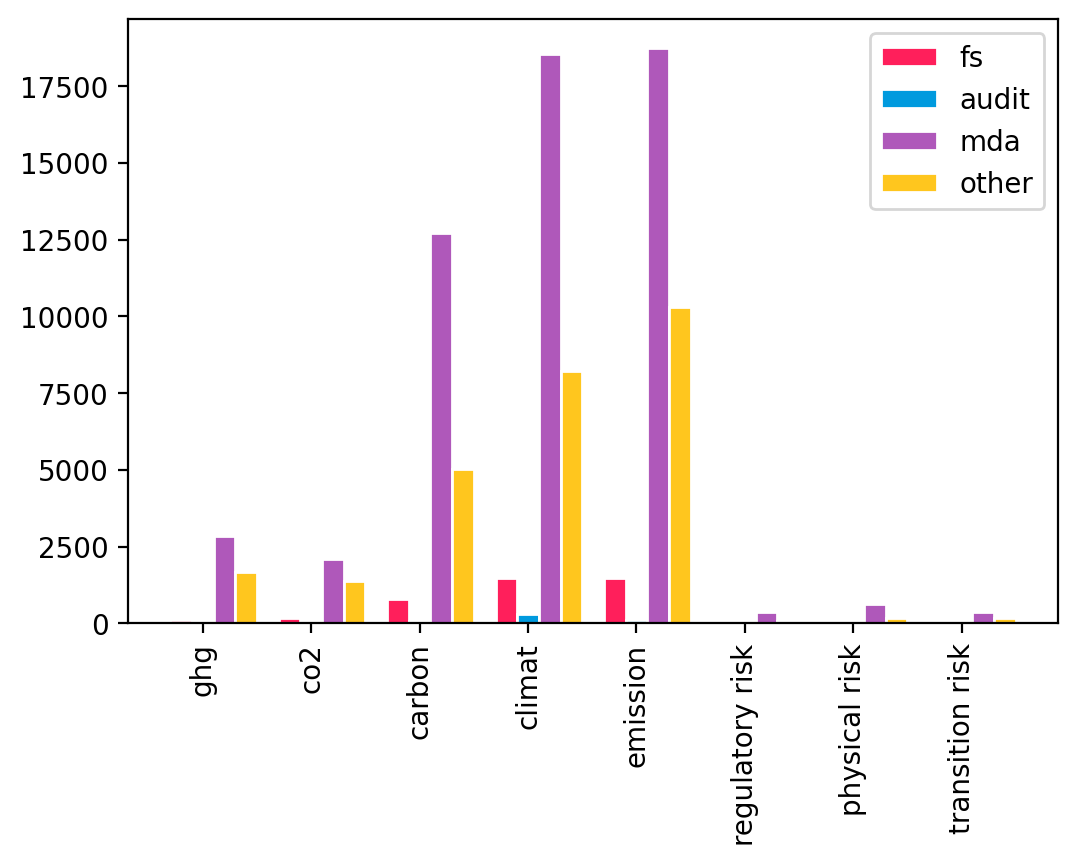

In [136]:
#| label: fig-fig202309281111
#| fig-cap: Keyword ranking by section
fig, ax = plt.subplots()

width = 0.2
label_locs = np.arange(len(search_patterns))
multiplier = 0

for sec, byKeyword in totals.items():
    offset = width * multiplier
    ax.bar(label_locs+offset, byKeyword, width=width, label=sec, edgecolor='w')
    #ax.bar_label(rects, padding=3)
    multiplier += 1
    
ax.set_xticks(label_locs+width)
ax.set_xticklabels(search_patterns)
plt.xticks(rotation=90)
ax.legend(loc='upper right')

plt.savefig('figures/fig202309272147.png', dpi=400, bbox_inches='tight')

## Heatmap of hits in the document

In [27]:
data1 = pd.DataFrame(columns=[
    'document_id', 'company_id', 'year', 'fs_begin', 'fs_end', 'audit_begin', 'audit_end', 
    'pattern', 'section', 'page'
])

for doc_id, doc in docsa.iterrows():
    for _, hit in doc.hits.iterrows():
        if (hit.section == 'fs') or (hit.section == 'audit'):
            data1.loc[len(data1)] = [
                doc_id, doc.company_id, doc.year, doc.fs_begin, doc.fs_end, doc.audit_begin, doc.audit_end,
                hit.pattern, hit.section, hit.page
            ]

In [114]:
data1_onlyFS    = data1.query('section == "fs"').drop(['audit_begin', 'audit_end', 'section'], axis=1)
data1_onlyaudit = data1.query('section == "audit"').drop(['fs_begin', 'fs_end', 'section'], axis=1)

In [115]:
data1_onlyFS_noMult = data1_onlyFS[[',' not in str(x) for x in data1_onlyFS['fs_begin']]]
data1_onlyaudit_noMult = data1_onlyaudit[[',' not in str(x) for x in data1_onlyaudit['audit_begin']]]
print('By restricting to no multi-start sections, we lose', 
      len(data1_onlyFS)-len(data1_onlyFS_noMult), 'snippets.\n',
      'Left:', len(data1_onlyFS_noMult))

By restricting to no multi-start sections, we lose 34 snippets.
 Left: 4178


In [116]:
data1_onlyFS_noMult['location'] = [int(snip['page']) / int(snip['fs_end']) for _,snip in data1_onlyFS_noMult.iterrows()]
data1_onlyaudit_noMult['location'] = [int(snip['page']) / int(snip['audit_end']) for _,snip in data1_onlyaudit_noMult.iterrows()]

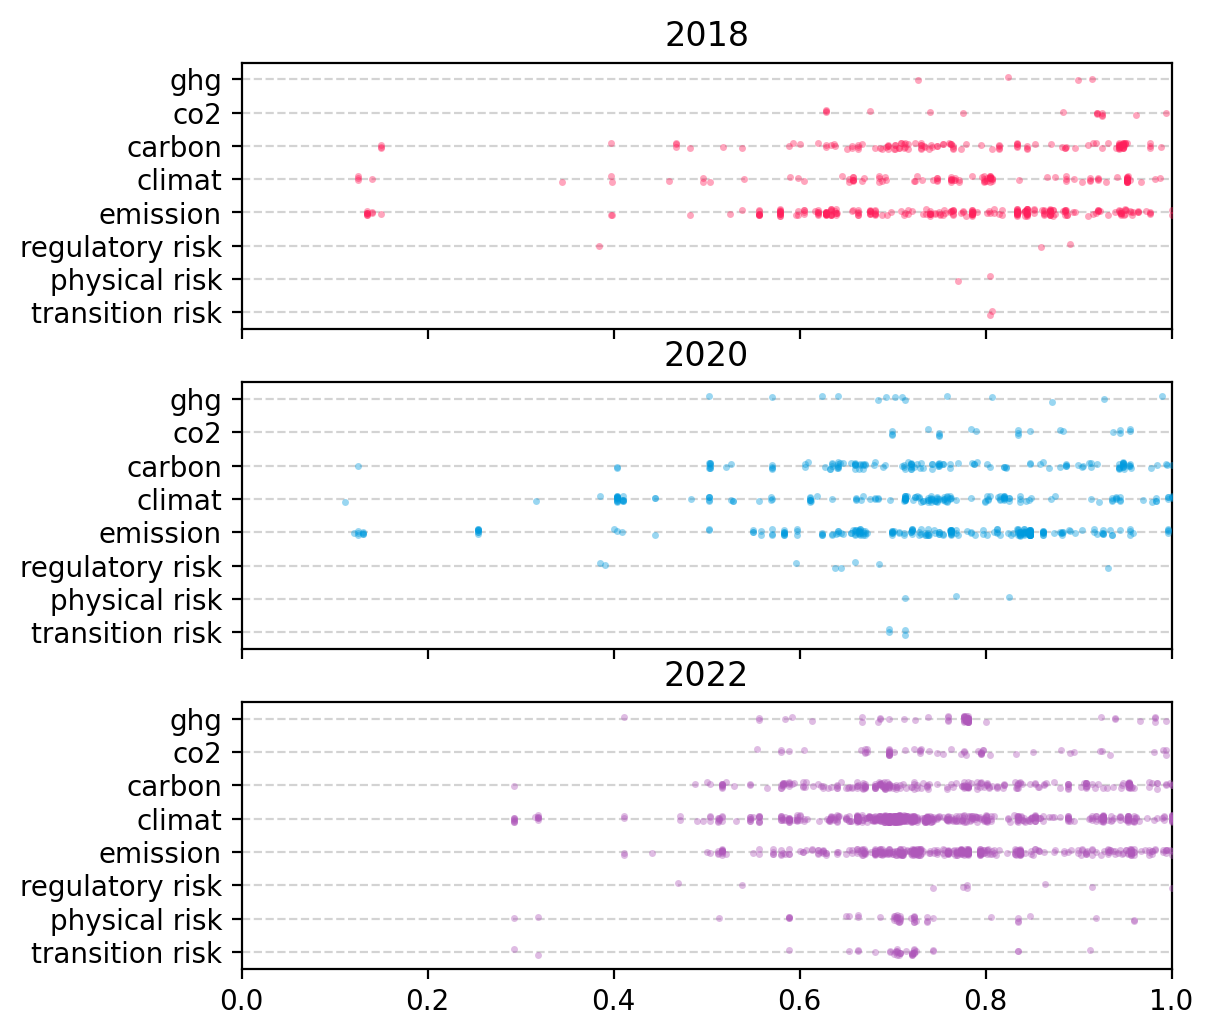

In [124]:
#| label: fig-fig202309282020
#| fig-cap: Relative location
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6,6))

customprops = dict(linestyle='--', linewidth=1, color='gray')

# ax.boxplot(data1_onlyFS_noMult['location'], showfliers=0, showmeans=1, meanline=1, showcaps=0, 
#            boxprops=customprops, whiskerprops=customprops, capprops=customprops, 
#            medianprops=dict(color='#ff1f5b'), meanprops=dict(linestyle=':', linewidth=1, color='gray'))

for n, year in enumerate([2018, 2020, 2022]):
    sns.stripplot(data=data1_onlyFS_noMult.query('year == @year'), 
                  x='location', y='pattern', 
                  color=colors[n], alpha=0.4, size=2.5, ax=ax[n], order=search_patterns)
    ax[n].grid(color='lightgray', axis='y', linestyle='dashed')
    ax[n].set_ylabel('')
    ax[n].set_title(year)
    

ax[0].set_xlim([0,1])
ax[2].set_xlabel('')

plt.show()

## Cross-sectional splits

In [651]:
snippets[snippets.document_id == 'f6d019db-5b4d-4b4b-b989-427262d0873b'].query('section == "fs"')

,document_id,isin,year,pattern,section,snippet
87779,f6d019db-5b4d-4b4b-b989-427262d0873b,DE000DTR0CK8,2021,carbon,fs,"joint venture in january 2022, daimler truck ..."
87780,f6d019db-5b4d-4b4b-b989-427262d0873b,DE000DTR0CK8,2021,emission,fs,t can only remain successful over the longterm...
87781,f6d019db-5b4d-4b4b-b989-427262d0873b,DE000DTR0CK8,2021,emission,fs,ainable corporate governance. this includes th...
87782,f6d019db-5b4d-4b4b-b989-427262d0873b,DE000DTR0CK8,2021,emission,fs,echnology path in the future and explore the p...
87783,f6d019db-5b4d-4b4b-b989-427262d0873b,DE000DTR0CK8,2021,emission,fs,orecasted planning periods as well as within c...
87784,f6d019db-5b4d-4b4b-b989-427262d0873b,DE000DTR0CK8,2021,emission,fs,her european truck manufacturers for their par...


## Interactive

In [608]:
# #| fig-cap: Average keyword hits per section over time
# fig, ax1 = plt.subplots()

# ax1.plot(years, avg_hits_perSec_perYear[0], 'o-', color='#ff1f5b', label='fs+notes')
# ax1.plot(years, avg_hits_perSec_perYear[1], 'o-', color='#009ade', label='audit')

# ax1.set_ylabel('average hits per section')
# ax1.set_xticks(years)
# ax1.legend()

# plt.show()

IntSlider(value=0)

## Document descriptives 

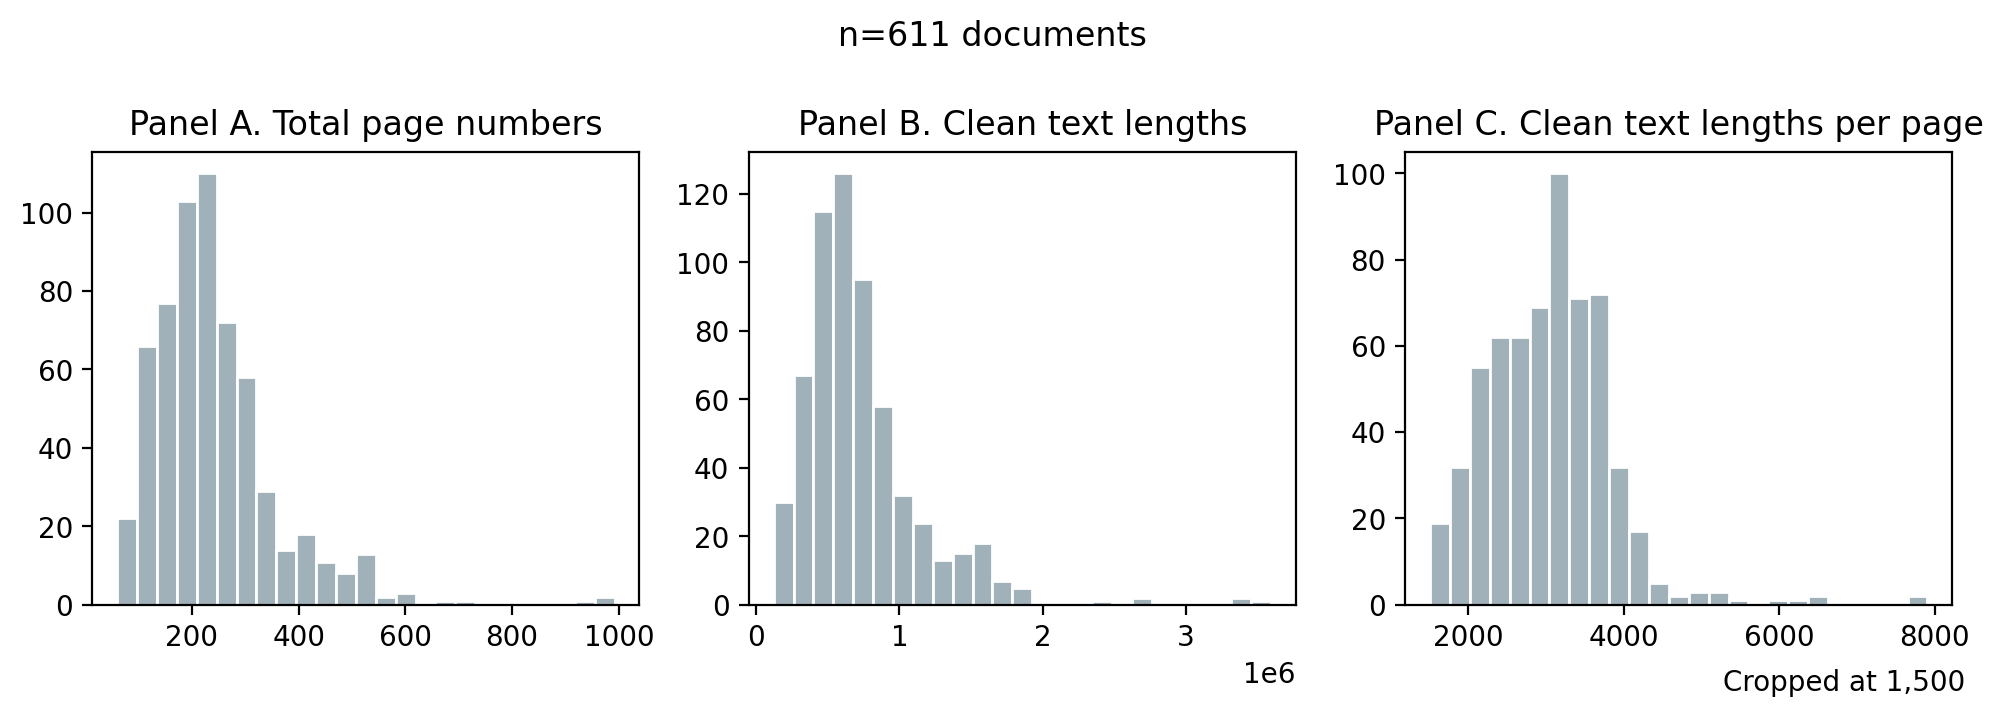

In [425]:
#| label: fig-fig202309281148
#| fig-cap: Document descriptives
fig, ax = plt.subplots(1,3, figsize=(12,3))

ax[0].hist(docsa['n_pages'], edgecolor="w", bins=25, color='#a0b1ba')
ax[0].set_title(f'Panel A. Total page numbers')

ax[1].hist(docsa['clean_text_len'], edgecolor="w", bins=25, color='#a0b1ba')
ax[1].set_title(f'Panel B. Clean text lengths')

ax[2].hist(docsa['avgCleanTextPerPage'], edgecolor="w", bins=25, color='#a0b1ba')
ax[2].set_title(f'Panel C. Clean text lengths per page')
ax[2].text(x=8400, y=-20, s=f'Cropped at 1,500', ha='right')

fig.suptitle(f"n={len(docsa)} documents", y=1.1)
plt.show()
#fig.savefig('figures/fig202309272049.png', dpi=400, bbox_inches='tight')

In [576]:
import nltk

In [577]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
x = sent_tokenize(docsa.iloc[0]['fs_text'])
x